Класифікація імен за допомогою RNN на рівні символів
==============================================================


Ми будемо створювати та навчати базову рекурентну нейронну мережу (RNN) на рівні символів для класифікації слів.Побудуэмо RNN з нуля, аби зрозуміти, як вона працює, а також побачимо, як можна покращити модель.

Рекурентна нейронна мережа на рівні символів читає слова як серію символів, видаючи прогноз та "прихований стан" (hidden state) на кожному кроці, передаючи свій попередній прихований стан на кожен наступний крок. Ми беремо фінальний прогноз як вихід, тобто, до якого класу належить слово.

Конкретно, ми будемо навчатися на кількох тисячах прізвищ з 18 мов походження та прогнозувати, з якої мови походить ім'я на основі його написання:

``` {.sourceCode .sh}
$ python predict.py Hinton
(-0.47) Шотландська
(-1.52) Англійська
(-3.57) Ірландська

$ python predict.py Schmidhuber
(-0.19) Німецька
(-2.48) Чеська
(-2.68) Голландська
```

Підготовка даних
------------------

Завантажимо дані names.zip та розпакуємо їх у поточний каталог.


In [ ]:
!unzip names.zip

Archive:  names.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [ ]:
!ls

У каталозі `data/names` містяться 18 текстових файлів, названих як `[Language].txt`. Кожен файл містить безліч імен, по одному імені на рядок, в основному романізованих (але нам все ще потрібно конвертувати імʼя з Unicode в ASCII).

Конвертація імен із Unicode в ASCII часто необхідна в задачах машинного навчання для стандартизації даних. Імена з різних мов можуть містити діакритичні знаки або символи, які відрізняються від стандартної латиниці. Це може ускладнити обробку текстових даних, особливо якщо ви використовуєте алгоритми, які менш стійкі до варіацій символів або якщо ваша модель потребує одноманітного набору символів.

Ми в результаті наступної попередньої обробки отримаємо словник списків імен за мовами, `{language: [names ...]}`. Загальні змінні "category" та "line" (для мови та імені в нашому випадку) використовуються для подальшої розширюваності.

In [ ]:
from io import open
import glob
import os

# Знаходить всі файли за вказаним шляхом
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Перетворює рядок Unicode в простий ASCII, дякуємо https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

['data/names/Polish.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Dutch.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/French.txt', 'data/names/Czech.txt', 'data/names/Chinese.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/English.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Vietnamese.txt', 'data/names/Greek.txt']
Slusarski


In [ ]:
# Створюємо словник category_lines, список імен для кожної мови
category_lines = {}
all_categories = []

# Читає файл і розділяє на рядки
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Проходимо по кожному файлу у вказаній директорії
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]  # Отримуємо назву категорії з імені файлу
    all_categories.append(category)  # Додаємо категорію до списку всіх категорій
    lines = readLines(filename)  # Читаємо всі рядки з файлу
    category_lines[category] = lines  # Додаємо список імен до словника за категоріями

n_categories = len(all_categories)  # Визначаємо кількість категорій

Тепер у нас є `category_lines`, словник, що відображає кожну категорію (мову) на список рядків (імен). Ми також створили `all_categories` (просто список мов) та `n_categories` для подальшого використання.

In [ ]:
# category_lines

In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [ ]:
print(category_lines['Polish'][:5])

['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz']


Маємо 20 тис імен до слова:

In [ ]:
sum(len(v) for v in category_lines.values())

20074

In [ ]:
{k: len(v) for k,v in category_lines.items()}

{'Polish': 139,
 'Korean': 94,
 'Italian': 709,
 'Dutch': 297,
 'Russian': 9408,
 'Scottish': 100,
 'French': 277,
 'Czech': 519,
 'Chinese': 268,
 'Japanese': 991,
 'Spanish': 298,
 'English': 3668,
 'Irish': 232,
 'Arabic': 2000,
 'German': 724,
 'Portuguese': 74,
 'Vietnamese': 73,
 'Greek': 203}

Перетворення імен на тензори
==========================

Тепер, коли ми організували всі імена, нам потрібно перетворити їх на тензори, щоб мати можливість їх використовувати.

Щоб представити одну літеру, ми використовуємо "one-hot вектор" (one-hot vector) розміру `<1 x n_letters>`. One-hot вектор заповнений 0, за винятком 1 на індексі поточної літери, наприклад, `"b" = <0 1 0 0 0 ...>`.

Щоб створити слово, ми об'єднуємо кілька з цих векторів у 2D матрицю `<line_length x 1 x n_letters>`.

Цей додатковий 1 вимір потрібний, оскільки PyTorch вважає, що всі дані сформовані знаходиться в батчі - ми просто використовуємо розмір батча 1 тут. Насправді буває і unbayched input - але це рідкий кейс при тренуванні нейронних мереж.

In [ ]:
len(all_letters)

57

In [ ]:
all_letters.find('J')

35

In [ ]:
import torch

# Знаходимо індекс літери з all_letters, наприклад, "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Для демонстрації: перетворюємо літеру в тензор розміром <1 x n_letters>
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Перетворюємо рядок у тензор розміру <line_length x 1 x n_letters>,
# або масив векторів, що представляють літери у вигляді one-hot кодування
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
lineToTensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

Створення мережі
====================

Наступний клас RNN реалізує "ванільний RNN" і складається всього з 3 лінійних шарів,
які працюють з вхідними даними та прихованим станом, з шаром `LogSoftmax` після виходу.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.W_xh = nn.Linear(input_size, hidden_size)
        self.W_hh = nn.Linear(hidden_size, hidden_size)
        self.W_hy = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.W_xh(input) + self.W_hh(hidden))
        output = self.W_hy(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
rnn

RNN(
  (W_xh): Linear(in_features=57, out_features=128, bias=True)
  (W_hh): Linear(in_features=128, out_features=128, bias=True)
  (W_hy): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Щоб викликати одне відпрацювання цієї мережі (один крок), нам потрібно передати вхідні дані (в нашому випадку, тензор для поточної літери) та попередній прихований стан (який ми спочатку ініціалізуємо нулями). Ми отримаємо вихідні дані (ймовірність кожної мови) та наступний прихований стан (який ми зберігаємо для наступного кроку).

In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
output

tensor([[-2.9098, -3.0165, -3.1149, -2.8793, -2.9491, -2.8108, -2.9019, -2.9284,
         -2.8545, -2.9465, -2.8992, -2.8827, -2.8834, -2.9097, -2.7004, -2.8373,
         -2.7820, -2.8867]], grad_fn=<LogSoftmaxBackward0>)

In [ ]:
hidden

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
torch.exp(output)

tensor([[0.0545, 0.0490, 0.0444, 0.0562, 0.0524, 0.0602, 0.0549, 0.0535, 0.0576,
         0.0525, 0.0551, 0.0560, 0.0559, 0.0545, 0.0672, 0.0586, 0.0619, 0.0558]],
       grad_fn=<ExpBackward0>)

Задля ефективності ми не хочемо створювати новий тензор з літери для кожного кроку, тому ми будемо використовувати `lineToTensor` замість `letterToTensor` і використовувати зрізи. Це можна ще більше оптимізувати, попередньо обчисливши пакети (батчі) тензорів.

In [ ]:
input.shape

torch.Size([6, 1, 57])

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden) # виклик знову ж тільки на одній літері
output, next_hidden = rnn(input[1], next_hidden)
output, next_hidden = rnn(input[2], next_hidden)
output, next_hidden = rnn(input[3], next_hidden)
output, next_hidden = rnn(input[4], next_hidden)
output, next_hidden = rnn(input[5], next_hidden)
print(output)

tensor([[-2.8688, -3.2183, -3.0249, -2.9251, -2.8807, -2.8863, -2.8853, -2.9056,
         -2.8204, -2.8186, -3.0145, -2.8097, -2.9724, -2.8327, -2.8390, -2.7952,
         -2.7473, -2.8777]], grad_fn=<LogSoftmaxBackward0>)


In [ ]:
torch.exp(output)

tensor([[0.0568, 0.0400, 0.0486, 0.0537, 0.0561, 0.0558, 0.0558, 0.0547, 0.0596,
         0.0597, 0.0491, 0.0602, 0.0512, 0.0589, 0.0585, 0.0611, 0.0641, 0.0563]],
       grad_fn=<ExpBackward0>)

Як ви можете бачити, вихід є тензором `<1 x n_categories>`, де кожен елемент є ймовірністю цієї категорії (вища ймовірність означає більшу ймовірність).

Навчання
========

Підготовка до навчання
----------------------

Перед початком навчання ми повинні створити кілька допоміжних функцій. Перша з них - це інтерпретація виходу мережі, який ми знаємо як ймовірність кожної категорії. Ми можемо використовувати `Tensor.topk`, щоб отримати індекс найбільшого значення:

In [ ]:
all_categories[10]

'Spanish'

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 16)


Ми також хочемо швидкий спосіб отримати приклад з навчального набору даних (ім'я та його мова):

In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Janick
category = Spanish / line = Santos
category = Dutch / line = Buggenum
category = German / line = Laurenz
category = Chinese / line = Ying
category = Portuguese / line = Esteves
category = English / line = Wainwright
category = German / line = Gerst
category = Portuguese / line = Madeira
category = Italian / line = Rossini


Навчання мережі
====================

Тепер все, що потрібно для навчання цієї мережі, це показати їй кілька прикладів, дати їй можливість зробити припущення і сказати, якщо вона помиляється.

### Різниця Softmax і LogSoftmax

**Softmax** і **log softmax** — це функції, які перетворюють вихідні значення нейронної мережі (зазвичай звані логітами) у ймовірності або лог-імовірності.

### 1. **Softmax**
**Softmax** перетворює вихідні значення (логіти) на ймовірності, які сумуються до 1. Це часто використовується в задачах класифікації, коли модель має передбачити, до якого класу належить об'єкт.

- **Формула**:
  $$
  \text{softmax}(x_i) = \frac{\exp(x_i)}{\sum_{j} \exp(x_j)}
  $$
  Де $x_i$ — це логіти (сирі вихідні значення) для кожного класу.

- **Пояснення**:
  Softmax бере логіти (які можуть бути будь-якими реальними числами) та перетворює їх на ймовірності. Результат для кожного класу буде числом між 0 і 1, і сума всіх ймовірностей дорівнюватиме 1. Це корисно для інтерпретації передбачень моделі у задачах багатокласової класифікації.

### 2. **Log Softmax**
**Log softmax** — це логарифм функції softmax. Він безпосередньо обчислює лог-імовірності для кожного класу.

- **Формула**:
  $$
  \text{log softmax}(x_i) = \log\left(\frac{\exp(x_i)}{\sum_{j} \exp(x_j)}\right) = x_i - \log\left(\sum_{j} \exp(x_j)\right)
  $$
  
  Тут видно, що log softmax об'єднує обчислення softmax і логарифма в один крок.

- **Пояснення**:
  Замість того, щоб спочатку обчислювати ймовірності, а потім брати логарифм (як це робить комбінація softmax і log), log softmax напряму обчислює логарифм від результатів softmax. Це дозволяє уникнути нестабільності та покращує точність обчислень.

### Переваги **log softmax** порівняно з **softmax**:

1. **Числова стабільність**:
   Функція softmax передбачає обчислення експонент для логітів. Якщо логіти дуже великі або дуже малі, експоненти можуть призвести до числових переповнень або втрати точності. Log softmax уникає цього, оскільки вона обчислює логарифм одночасно з експонентами, що допомагає уникнути великих чисел.

2. **Ефективність обчислень**:
   Log softmax поєднує дві операції (softmax і логарифм) в одну. Це економить час і ресурси, оскільки вам не потрібно обчислювати softmax, а потім брати від нього логарифм, як це було б при окремому використанні.

3. **Сумісність із функцією втрат**:
   Log softmax добре підходить для використання разом із функцією втрат, наприклад, негативною логарифмічною правдоподібністю (NLLLoss). Це часто використовується для багатокласової класифікації, де ми працюємо з лог-імовірностями замість ймовірностей.


### Приклад для пояснення:

- **Softmax**: Якщо модель передбачає логіти для класів $ [2.0, 1.0, 0.1] $, softmax перетворить ці логіти на ймовірності, наприклад: $ [0.65, 0.24, 0.11] $.
  
- **Log softmax**: Замість цього, log softmax видасть значення $ [-0.43, -1.43, -2.33] $, що є логарифмами ймовірностей. Це дає таку ж інформацію, але у вигляді логарифмів, що зручніше для обчислень у задачах оптимізації.

Для функції втрат `nn.NLLLoss` є доречною, оскільки останній шар RNN - це `nn.LogSoftmax`. Чому так:

1. **LogSoftmax**:
   - `nn.LogSoftmax` — це варіант функції softmax, яка перетворює логіти (сирі виходи нейронної мережі) на логарифми ймовірностей. Це потрібно, коли ми хочемо отримати розподіл ймовірностей по класах, але замість самих ймовірностей ми використовуємо їхні логарифми. Тобто, якщо звичайний softmax перетворює значення в ймовірності, сума яких дорівнює 1, то `LogSoftmax` дає логарифми цих ймовірностей.

2. **NLLLoss (Negative Log Likelihood Loss)**:
   - `nn.NLLLoss` розраховує втрати на основі негативного логарифму ймовірностей для правильного класу. Вона передбачає, що ви передаєте в неї логарифми ймовірностей, а не самі ймовірності. Тобто замість звичайних ймовірностей (як у softmax), вона працює з результатами `LogSoftmax`.

3. **Взаємодія LogSoftmax і NLLLoss**:
   - Оскільки `nn.NLLLoss` працює з логарифмами ймовірностей, попередній шар має саме такі значення генерувати. І тут приходить на допомогу `nn.LogSoftmax`, який саме і повертає логарифми ймовірностей.
   - Якщо останній шар нейронної мережі — це `nn.LogSoftmax`, він генерує логарифми ймовірностей для кожного класу, і ці значення потім передаються у функцію втрат `nn.NLLLoss`, яка на основі них обчислює втрати.

Основна різниця між **NLLLoss** та **CrossEntropyLoss** у нейронних мережах полягає в тому, чи потрібно явно застосовувати функцію **softmax**. Давайте розглянемо детальніше:

### 1. **NLLLoss (Negative Log Likelihood Loss – Втрата негативної логарифмічної правдоподібності)**
- **Формула**: Дано $ p $, що представляє розподіл ймовірностей (зазвичай отримується за допомогою softmax), і правильний клас $ y $, NLLLoss обчислює:
  $$
  \text{NLLLoss} = -\log(p(y))
  $$
  Де $ p(y) $ – це передбачувана ймовірність правильного класу.

- **Коли використовувати**: Ви зазвичай використовуєте **NLLLoss**, коли модель видає лог-імовірності напряму, що є випадком, коли ви застосовуєте **log softmax** до виходу моделі. Ця функція вимагає, щоб вхідними даними були лог-імовірності, а не сирі оцінки або ймовірності.

- **Потрібен softmax**: Вихід моделі вже має бути у вигляді логарифмованих ймовірностей (наприклад, за допомогою `torch.nn.LogSoftmax` у PyTorch). В іншому випадку функція втрат не працюватиме належним чином.

### 2. **CrossEntropyLoss (Перехресна ентропія)**
- **Формула**: Перехресна ентропія поєднує як softmax, так і негативну логарифмічну правдоподібність в один етап. Формула виглядає так:
  $$
  \text{CrossEntropyLoss} = -\log\left(\frac{\exp(x_y)}{\sum_{j} \exp(x_j)}\right)
  $$
  Де $ x_j $ представляє сирі оцінки (логіти) для кожного класу, а $ x_y $ – це оцінка для правильного класу.

- **Коли використовувати**: Використовуйте **CrossEntropyLoss**, коли ваша модель видає сирі логіти (ненормалізовані оцінки). Ця функція автоматично застосовує softmax внутрішньо, а потім обчислює логарифмічну правдоподібність, тому вам не потрібно застосовувати softmax вручну.

- **Потрібен softmax**: CrossEntropyLoss **включає** softmax внутрішньо, тому ви подаєте сирі оцінки (логіти) без додаткової обробки.

### Підсумок різниць:
- **NLLLoss** вимагає, щоб ви вручну застосували **log softmax** до виходу моделі. Вона працює безпосередньо з лог-імовірностями.
- **CrossEntropyLoss** внутрішньо виконує softmax і NLL за один крок, тому ви можете подавати сирі логіти без попередньої обробки.


Обидві функції втрат працюють подібно, але мають різні вимоги до вхідних даних. **CrossEntropyLoss** частіше використовується, оскільки спрощує процес, поєднуючи крок softmax внутрішньо.

Приклад:



In [ ]:
import torch
import torch.nn as nn

# Приклад для CrossEntropyLoss
logits = torch.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])  # сирі оцінки
targets = torch.tensor([2, 1])  # індекси правильних класів

cross_entropy_loss = nn.CrossEntropyLoss()
loss_ce = cross_entropy_loss(logits, targets)

# Приклад для NLLLoss
log_probs = torch.nn.functional.log_softmax(logits, dim=1)  # застосування log softmax
nll_loss = nn.NLLLoss()
loss_nll = nll_loss(log_probs, targets)

print(loss_ce, loss_nll)

tensor(0.9076) tensor(0.9076)


In [ ]:
criterion = nn.NLLLoss()

Кожен цикл навчання буде:

-   Створювати вхідні та цільові тензори
-   Створювати нульовий початковий прихований стан
-   Читати кожну літеру і
    -   Зберігати прихований стан для наступної літери
-   Порівнювати фінальний вихід з ціллю
-   Виконувати зворотне поширення (back-propagate)
-   Повертати вихід та втрати (loss)

In [ ]:
learning_rate = 0.005 # Якщо ви встановите його занадто високим, градієнти можуть почати вибухати. Якщо занизьке, то може не навчитися модель

def train(rnn, category_tensor, line_tensor):
    "Опрацюванння одного екземпляра даних."
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # Порівнюємо пеердбачену категорію, отриману після опрацювання всієї послідовності
    # зі справжнім значенням
    loss = criterion(output, category_tensor)
    loss.backward()

    # Додаємо градієнти параметрів до їхніх значень, помножені на швидкість навчання
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Тепер нам просто потрібно запустити це з великою кількістю прикладів. Оскільки функція `train` повертає як вихід, так і втрати, ми можемо вивести прогнози та також відстежувати втрати для побудови графіка. Оскільки у нас є тисячі прикладів, ми виводимо лише кожні `print_every` прикладів і беремо середнє значення втрат.

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Збираємо лоси для графіку
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(rnn, category_tensor, line_tensor)
    current_loss += loss

    # Друкуємо номер ітерації ``iter``, loss, імʼя і передбачення мови
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Додаємо поточний середній лосс до списку відстеження лосів
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.1278 Ansaldi / Japanese ✗ (Italian)
10000 10% (0m 18s) 1.5802 Flann / Irish ✓
15000 15% (0m 28s) 2.0691 D'cruz / Spanish ✗ (Portuguese)
20000 20% (0m 38s) 0.7944 Bursinos / Greek ✓
25000 25% (0m 48s) 0.5505 Chu / Vietnamese ✓
30000 30% (0m 56s) 2.9094 Keay / Arabic ✗ (English)
35000 35% (1m 6s) 2.0690 Gonzales / Greek ✗ (Spanish)
40000 40% (1m 15s) 0.7444 Buhr / German ✓
45000 45% (1m 25s) 1.1374 Zajicek / Polish ✗ (Czech)
50000 50% (1m 34s) 0.3577 Tong / Vietnamese ✓
55000 55% (1m 43s) 0.0310 Kowalski / Polish ✓
60000 60% (1m 52s) 0.2751 Savatier / French ✓
65000 65% (2m 1s) 0.6418 Jeon / Korean ✓
70000 70% (2m 10s) 0.3726 Lindsay / Scottish ✓
75000 75% (2m 20s) 1.1223 Sandoval / Spanish ✓
80000 80% (2m 29s) 0.3418 Eoin / Irish ✓
85000 85% (2m 37s) 1.0167 D'ambrosio / Italian ✓
90000 90% (2m 47s) 0.0159 Kreskas / Greek ✓
95000 95% (2m 56s) 1.4348 Baumgartner / Spanish ✗ (German)
100000 100% (3m 5s) 2.0137 Seow / Korean ✗ (Chinese)


Графік результатів
====================

Графік історичних втрат з `all_losses` показує, як мережа
навчається:

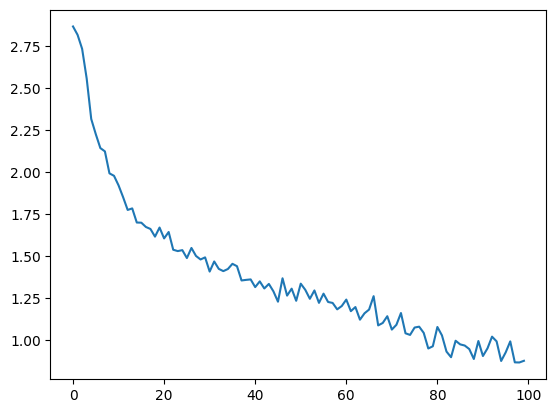

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Оцінка Результатів
======================

Щоб побачити, як добре мережа працює з різними категоріями, ми створимо матрицю плутанини (confusion matrix), яка вказує для кожної фактичної мови (рядки), яку мову мережа вгадує (стовпці). Для розрахунку матриці плутанини кілька зразків проходять через мережу з використанням `evaluate()`, що є тим самим, що й `train()`, за винятком зворотного поширення (backprop).

<ipython-input-37-0dded689a7e4>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-37-0dded689a7e4>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


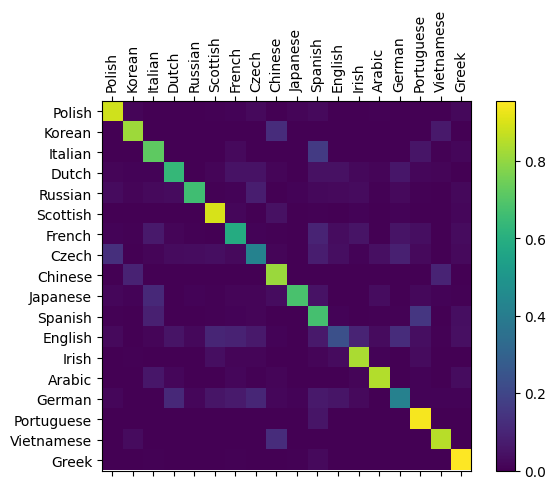

In [ ]:
# Просто повертає результат для переданої послідовності
def evaluate(line_tensor, rnn):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def plot_confusion(rnn):
  # Відстеження правильних здогадок у матриці плутанини
  confusion = torch.zeros(n_categories, n_categories)
  n_confusion = 10000

  # Проходження через безліч прикладів і запис правильних здогадок
  for i in range(n_confusion):
      category, line, category_tensor, line_tensor = randomTrainingExample()
      output = evaluate(line_tensor, rnn)
      guess, guess_i = categoryFromOutput(output)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1

  # Нормалізація шляхом ділення кожного рядка на його суму
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()

  # Налаштування графіка
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)

  # Налаштування осей
  ax.set_xticklabels([''] + all_categories, rotation=90)
  ax.set_yticklabels([''] + all_categories)

  # Встановлення підпису на кожній мітці
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # sphinx_gallery_thumbnail_number = 2
  plt.show();

plot_confusion(rnn)

Ви можете виділити яскраві точки поза основною віссю, які показують, які мови вона вгадує неправильно, наприклад, китайську для корейської та іспанську для італійської. Здається, вона дуже добре справляється з грецькою, а дуже погано з англійською (можливо, через перетин з іншими мовами).

Запуск на основі введення користувача
=====================

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), rnn)

        # Отрмуємо топ N категорій
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Pylieva')
predict('Jackson')
predict('Satoshi')
predict('Trump')


> Pylieva
(-0.52) Czech
(-0.98) Spanish
(-3.91) Italian

> Jackson
(-0.22) Scottish
(-1.85) English
(-3.93) Greek

> Satoshi
(-0.17) Japanese
(-2.21) Italian
(-3.44) Arabic

> Trump
(-0.84) Vietnamese
(-1.44) German
(-2.09) English


In [ ]:
predict('London')


> London
(-0.80) English
(-1.65) French
(-2.18) German


Ми можемо побачити, як цей скрипт можна розіділити на декілька Python файлів [в репозиторії Practical PyTorch](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification):

-   `data.py` (завантажує файли)
-   `model.py` (визначає RNN)
-   `train.py` (запускає навчання)
-   `predict.py` (запускає `predict()` з аргументами командного рядка)
-   `server.py` (надає прогноз як JSON API з `bottle.py`)

Запустіть `train.py`, щоб навчити та зберегти мережу.

Запустіть `predict.py` з ім'ям, щоб переглянути прогнози:

``` {.sourceCode .sh}
$ python predict.py Hazaki
(-0.19) Polish
(-2.16) Japanese
(-3.56) Czech
```

Запустіть `server.py` і відвідайте <http://localhost:5533/Yourname>, щоб отримати JSON вихід прогнозів.

Переглянути як в подібному стилі можна для цієї задачі написати рішення з використанням LSTM і наскільки це поліпшить сиутацію можна [тут](https://github.com/yk287/Name_Classification).

Що робити далі?
=========

-   Можна той самий підхід використовувати з іншим набором даних лінія -\> категорія, наприклад:
    -   Будь-яке слово -\> мова
    -   Ім'я -\> стать
    -   Ім'я персонажа -\> письменник
    -   Назва сторінки -\> блог або сабреддіт
-   Можна спробувати отримати кращі результати з більшою та/або краще сформованою мережею
    -   Додайте більше лінійних шарів
    -   Спробуйте шари `nn.LSTM` та `nn.GRU`
    -   Поєднайте кілька з цих RNN як мережу вищого рівня